# ADM-HW4

## 1. Hashing task!

The first step to take is to create the class for the **BloomFilter**.  

The Bloom filter has to take in input the *number of total items* that will be added to it and the *false-positive probability* desired.  
Given this 2 variables as input, the filter has to automatically calculate the length needed for the array and the number of hash functions needed to achieve the requested FP-prob.  

The BloomFilter is also resposible for *adding* new items and for *checking* if some items are already added to it. For completing this tasks we also need to define a hash function which, given an item, returns the position of the array that has to be turned from 0 to 1. Given the fact that we could need more than 1 hash function, the one actually defined depends on a seed, so if we give in input the same item, but with a different seed, the function returns a different integer.

The hash function used is based on the **DJB2-H method**, introduced by Daniel J. Bernstein.  
The concept is pretty simple:  
1. start with a hash_code equal to 0  
2. for each character in the string take its ASCII integer value and sum it to the hash_code multiplied by a prime number. The prime number used in this case is 31 since it has been proved to produce optimal results.  
3. since we want a family of k hash functions, multiply the ASCII value by a seed, depending on the number of the hash function utilized at the moment.

Before usinge the *DJB2-H* method we tried with the *multiplication method* but the results obtained were far less optimal.

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import time

In [2]:
class BloomFilter(object):
    """
    This class contains the variable and the methods needed for the implementation and use
    of a Bloom Filter
    """
     
    def __init__(self, n_items, fp_prob, hash_count = 0):
        self.fp_prob = fp_prob  # false positive probability
        self.n_items = n_items  # number of items to add to the filter
        self.array_len = self.get_array_len(self.n_items, self.fp_prob)  # length of the array
        self.hash_count = hash_count  # number of hash functions needed
        if hash_count == 0:
            self.hash_count = self.get_hash_count(self.n_items, self.array_len)
        self.array = np.zeros(self.array_len, dtype=int)  # array initialized to all zeros

    def get_array_len(self, n, p):
        """
        Calculate the length of the array needed with n items and a required false positive prob p.
        """
        m = -(n*math.log(p))/(math.log(2)**2)
        return int(m)

    def get_hash_count(self, n, m):
        """
        Calculate the number of hash functions needed with n items to achieve p false positive prob.
        """
        k = (m/n)*math.log(2)
        return int(k)

    def hash(self, s, seed):
        """
        Given a string s and an int seed, calculate the hash code of the string using the DJB2-H method.
        """
        g = 31
        res = 1

        for c in s:
            res = g*res + ord(c)*seed

        return (res % self.array_len)

    def add(self, s):
        """
        Add a string s to the Bloom filter.
        """
        for i in range(1, self.hash_count + 1):
            index = self.hash(s, i)  # get hash value
            self.array[index] = 1  # set the corresponding index of the array to 1

    def exists(self, s):
        """
        Check if the filter contains a string s.
        """
        for i in range(1, self.hash_count + 1):
            index = self.hash(s, i)
            if self.array[index] == 0:
                return False
        return True

    def describe(self):
        """
        Print the main info about the filter.
        """
        print("False-positive probability (%): ", self.fp_prob*100)
        print("Number of items: ", self.n_items)
        print("Array length: ", self.array_len)
        print("Number of hash functions: ", self.hash_count)

Now we are going to demostrate that the hash function generates integers with a normal distribution over the total array length. We will use just 100k passwords for this simulation.

In [3]:
passwords1_path = "data\passwords\passwords1.txt"
passwords2_path = "data\passwords\passwords2.txt"

In [4]:
n = 100000
BF = BloomFilter(n, 0.001)
m = BF.array_len
k = BF.hash_count

In [5]:
print(m)
print(k)

1437758
9


In [6]:
ls_hash = []
with open(passwords1_path, 'r') as passwords1:
    for j, pwd in enumerate(passwords1):
        if j == n:
            break
        for i in range(1, k+1):
            ls_hash.append(BF.hash(pwd, i))

Here are some results:

In [7]:
hash_series = pd.Series(ls_hash)
hash_series.describe()

count    9.000000e+05
mean     7.188949e+05
std      4.152766e+05
min      1.000000e+00
25%      3.594315e+05
50%      7.183860e+05
75%      1.078774e+06
max      1.437757e+06
dtype: float64

First of all we can see that all of the integers generated are in the range from 0 to m

In [8]:
print("hash_series out of range: ", hash_series.max() > m or hash_series.min() < 0)

hash_series out of range:  False


Now we will plot the distribution of the integers to demonstrate that it is uniform

(array([18095., 18024., 18001., 18144., 17722., 17940., 18133., 17886.,
        18009., 17882., 18253., 18004., 18009., 18157., 18156., 17893.,
        17839., 18175., 18118., 17960., 18059., 17952., 18054., 17783.,
        18055., 17990., 18123., 17514., 17791., 17864., 18067., 17731.,
        17941., 18235., 18109., 18028., 17878., 18162., 17995., 18278.,
        17904., 17914., 17971., 17971., 17958., 18015., 18037., 18112.,
        18118., 17991.]),
 array([1.00000000e+00, 2.87561200e+04, 5.75112400e+04, 8.62663600e+04,
        1.15021480e+05, 1.43776600e+05, 1.72531720e+05, 2.01286840e+05,
        2.30041960e+05, 2.58797080e+05, 2.87552200e+05, 3.16307320e+05,
        3.45062440e+05, 3.73817560e+05, 4.02572680e+05, 4.31327800e+05,
        4.60082920e+05, 4.88838040e+05, 5.17593160e+05, 5.46348280e+05,
        5.75103400e+05, 6.03858520e+05, 6.32613640e+05, 6.61368760e+05,
        6.90123880e+05, 7.18879000e+05, 7.47634120e+05, 7.76389240e+05,
        8.05144360e+05, 8.33899480e+05

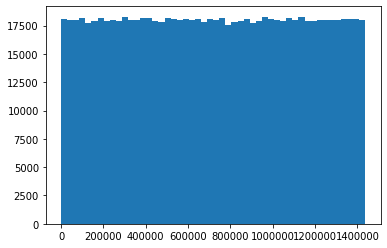

In [9]:
plt.hist(ls_hash, bins = 50)

### Bloom Filter Check on the entire dataset

Now we can define a new functions to add the passwords to the filter and check the duplicates from anoder list of passwords. We will also calculate the time needed for the process to complete.

In [15]:
def exec_bloom_filter(BF, passwords1_path, passwords2_path):
    """
    ADD the passwords in passwords1 to the filter and check how many passwords
    from passwords2 are duplicates.
    """
    start = time.time()

    # add the passwords from passwords1
    with open(passwords1_path, 'r') as passwords1:
        i = 0
        for pwd in passwords1:
            BF.add(pwd)
            if i%1000000 == 0:
                print(i)
            i += 1

    duplicates = 0
    # check the passwords in passwords2
    with open(passwords2_path, 'r') as passwords2:
        i = 0
        for pwd in passwords2:
            if i%1000000 == 0:
                print(i)
            if BF.exists(pwd):
                duplicates += 1
            i += 1
        
    end = time.time()
    
    # return the list of duplicates for eventually saving them in a file
    return (duplicates, int(end-start))

This is the number of passwords that we will add to the BloomFilter

In [10]:
n = 0
with open(passwords1_path, 'r') as passwords1:
    for pwd in passwords1:
        n += 1
n

100000000

In this case we will create a Bloom Filter with FP-prob equal to 0.1%.

In [14]:
BF = BloomFilter(n, 0.001)
BF.describe()

False-positive probability (%):  0.1
Number of items:  100000000
Array length:  1437758756
Number of hash functions:  9


In [16]:
(duplicates, seconds) = exec_bloom_filter(BF, passwords1_path, passwords2_path)

In [20]:
import gc
gc.collect()

3101

In [18]:
print('\nNumber of hash function used: ', BF.hash_count) 
print('Number of duplicates detected: ', duplicates) 
print('Probability of false positives: (%)', BF.fp_prob*100) 
print('Execution time: ', seconds, ' seconds')


Number of hash function used:  9
Number of duplicates detected:  16217499
Probability of false positives: (%) 0.1
Execution time:  4806  seconds


This are the results obtained:  
- **Number of hash functions used:** 9
- **Number of duplicates detected:** 16217499
- **Probability of false positives (%):** 0.1
- **Execution time:** 4806 seconds -> about 1 hour and 20 minutes

#### Another test with different parameters

Since the process didn't take too long, we can give it another try but with a smaller FP-Prob and consequently a bigger number of hash functions.

We will manually set the number of hash functions required because, even though the BF would calculate a hash_count equal to 13, by doing some math can be proved that an almost equal result can be achieved by using just 11 hash functions.

In [21]:
BF = BloomFilter(n, 0.0001, 11)
BF.describe()

False-positive probability (%):  0.01
Number of items:  100000000
Array length:  1917011675
Number of hash functions:  11


In [ ]:
(duplicates, seconds) = exec_bloom_filter(BF, passwords1_path, passwords2_path)

In [ ]:
print('\nNumber of hash function used: ', BF.hash_count) 
print('Number of duplicates detected: ', duplicates) 
print('Probability of false positives: (%)', BF.fp_prob*100) 
print('Execution time: ', seconds, ' seconds')

#### Some other stats

In [155]:
def count_equals(passwords1, passwords2):
    count = 0
    for p in passwords2:
        if p in passwords1:
            count += 1
    return count

In [ ]:
with open('duplicates.txt', 'w') as f:
    for pwd in duplicates:
        f.write("%s\n" % pwd)

In [67]:
test_pwd1 = passwords1[100000:300000]
test_pwd2 = passwords2[:30000]
BF = BloomFilter(len(test_pwd1), 0.001)
BF.describe()

False-positive probability (%):  0.1
Number of items:  200000
Array length:  2875517
Number of hash functions needed:  10


In [68]:
duplicates = exec_bloom_filter(BF, test_pwd1, test_pwd2)

Number of hash function used:  10
Number of duplicates detected:  1146
Probability of false positives: (%) 0.1
Execution time:  7  seconds


In [259]:
# total equals = 
CE = count_equals(test_pwd1, test_pwd2)

In [264]:
TN = len(test_pwd2) - CE
FP = duplicates - CE
FPR = FP / (FP + TN)
FPR*100

2.6281550871714807

## 2. Alphabetical Sort

In this section are contained the discussions regarding time complexity about the functions created for the resolution of the exercise.

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import string
import time

### Counting sort

**Counting sort** assumes that every int in the input, list with length *n*, is in the range *0 <= k <= n*. With this constraint we can assume that O(k) lies under O(n).

In [23]:
def counting_sort(A):
    """
    This function takes in input a list of integers and return a new ordered list, based on the first one.
    :param A: the list to order
    :type A: list of int
    :return: ordered list
    :rtype: list of int
    """
    k = max(A)  # O(n)
    n = len(A)  # O(1)
    B = [0 for i in range(n)]  # O(n)
    C = [0 for i in range(k+1)]  # O(k) -> O(n)

    for i in range(n):  # O(n)
        C[A[i]] += 1  # O(1)
        # each element C[i] is equal to the number of i in the array A

    for i in range(1, k+1):  # O(k) -> O(n)
        C[i] += C[i-1]  # O(1)
        # each C[i] is now equal to the number of elements in A equal or less than i

    for i in range(n-1, -1, -1):  # O(n)
        el = A[i]  # O(1)
        index = C[el]-1  # O(1)
        B[index] = el  # O(1)  # insert A[i] in the right position in B, given by C[i]-1
        C[el] += -1  # O(1)  # decrease by one the number of elements equal or less than A[i]

    return B

#### Sorting Test

In [25]:
k = 12  # maximum value
A = [random.randint(0, k) for i in range(20)]
A

[4, 0, 0, 10, 2, 11, 5, 12, 3, 5, 11, 11, 8, 7, 6, 11, 3, 1, 0, 4]

In [26]:
counting_sort(A)

[0, 0, 0, 1, 2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 10, 11, 11, 11, 11, 12]

#### Theoretical complexity

After analyzing the **counting_sort** function it is easy to calculate its time complexity, since it corresponds to a sum of complexities not bigger than **_O(n)_**. So, assuming O(k) = Theta(n), the total time complexity of the algorithm is **_O(n)_**.

Just in the case of *k* being bigger than *n*, then the complexity would be **O(n+k)**.

### Counting sort for alphabet letters

Given the counting_sort function it's easy to define a new function for ordering a list of char.

In [40]:
diff = ord('A') - 1

In [29]:
def char_couting_sort(lst):
    """
    This function takes in input a list of char and returns a new list, based on the first
    one but ordered alphabetically.
    :param lst: list of char
    :return: ordered list of char
    """
    A = [(ord(c)-diff) for c in lst]  # O(n)  # convert each char into an integer and put it into a list
    B = counting_sort(A)  # O(n)  # order the list
    return [chr(x+diff) for x in B]  # O(n)  # convert the integers into chars and return the list

The idea behing it is that each char in the english alphabet has a corresponding ASCII code. So we can convert the chars into integers, normalize them so that the first char has value 1, and order the list using the counting sort.

#### Theoretical complexity

All of the operations run in **O(n)** time: first the list of chars gets converted to a list of integers, then the list of integers gets ordered using the standard counting sort and finally the integers get re-converted to chars.

So, the final complexity is **O(n)**.

#### Empirical complexity

We can also demonstrate the previous theoretical complexity by simulation.

We are going to create a list of lists containing characters to be ordered. For each list we are going to save the time taken to sort it and then plot the durations of all the sorts.

In [35]:
lists_list = []  # list of lists of characters

for j in range(22):
    lst = []
    for i in range(2**j):
        # randomly take a char and add to the list
        lst.append(random.choice(string.ascii_letters))
    lists_list.append(lst)

lens = []  # length of each list
for lst in lists_list:
    lens.append(len(lst))
    
print(*lens)
print(*lists_list[2:5])

1 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 32768 65536 131072 262144 524288 1048576 2097152
['F', 'C', 'm', 'j'] ['k', 'c', 'v', 'A', 'a', 'a', 'P', 'i'] ['E', 'V', 'n', 'g', 'U', 'F', 'n', 's', 't', 'B', 'R', 'm', 'K', 'Z', 'l', 'E']


In [42]:
durations = []
for lst in lists_list:
    start = time.time()
    char_couting_sort(lst)
    durations.append(time.time() - start)

print(durations)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009970664978027344, 0.0, 0.0, 0.0, 0.0010077953338623047, 0.00199127197265625, 0.005662679672241211, 0.008533239364624023, 0.019891977310180664, 0.03595471382141113, 0.06482601165771484, 0.13280153274536133, 0.27427124977111816, 0.5934092998504639, 1.2309136390686035]


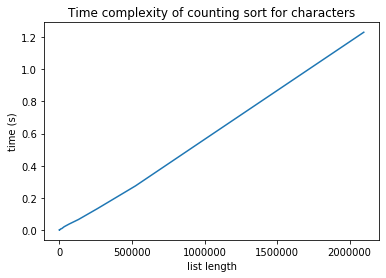

In [45]:
fig, ax = plt.subplots()
ax.plot(lens, durations)
ax.set(ylabel='time (s)', xlabel='list length',
       title='Time complexity of counting sort for characters')
plt.show()

From the plot it is easy to see that the theoretical complexity previously calculated is correct. In fact the algorithm has linear running time **O(n)**.

### Strings counting sort

To be able to order alphabetically a list of strings, we need to define to define 2 new different functions:  
1. An **imperative function** which orders a list of strings alphabetically based on the position of an internal character and, at the end, groups the strings by their char in position j and returns the new list of lists.  
2. A **recursive function** which launch the counting sort function over sublists of the initial list and, at the end, return a single list containing all the strings ordered alphabetically.


Let's define the imperative one and calculate it's complexity. It's important to specify that this function is just a minor variation of the counting sort function which orders lists of strings.

In [46]:
def strings_counting_sort(A, j):
    """
    This function takes in input a list and an integer j, 
    which is the index based on which the functions has to order the list of strings.
    It returns a list of lists. Each list has the strings grouped by the j_th item.
    :param A: list of strings to order
    :return: list of lists, ordered by the j_th item
    """
    diff = ord('A') - 1
    k = ord('z') - ord('A') + 1  # O(1)  # number of possible chars at position j
    n = len(A)  # O(1)
    C = [0 for i in range(k+1)]  # O(k)  # list to store the number of strings with the same char in position j
    to_return = []  # this list will store the strings whose length is equal or smaller than j

    for i in range(n):  # O(n)  # loop over the list of strings
        if len(A[i]) <= j:  # O(1)  # if the string doesn't have the j_th item, 
            # put the string in the to_return list and go directly to the next string.
            to_return.append(A[i])  # O(1)
            continue

        if A[i][j] == ' ':  # O(1)  # the *space* has index 0 (arbitrary choice)
            index = 0  # O(1)
        else:
            index = ord(A[i][j])-diff  # O(1)
            # the value in position *index* in C will be the number of strings containing
            # the same char in position j. (e.g. if j==3 and A[i][j] = 'a' then index = ord('a') = 1)
        C[index] += 1  # O(1)
        # each element C[i] is equal to the number of i in the array A

    # now remove from the list A the strings already ordered which are contained in to_return
    for word in to_return:  # O(n) # generally it is smaller than n
        A.remove(word)  # O(n) # this operation of removing take the total complexity of the algo to O(n^2)

    for i in range(1, k+1): # O(k)
        C[i] += C[i-1]  # O(1)
        # each C[i] is now equal to the number of elements in A equal or less than i

    n = len(A)  # re-calculate len(A) since there have been removed some strings
    B = [0 for i in range(n)]  # O(n)
    for i in range(n-1, -1, -1):  # O(n)
        char = ord(A[i][j])-diff  # O(1)
        if A[i][j] == ' ':  # O(1)  # the *space* has index 0 (arbitrary choice)
            char = 0  # O(1)
        index = C[char]-1  # O(1)
        B[index] = A[i]  # O(1) # insert A[i] in the right position in B, given by C[i]-1
        C[char] += -1  # O(1)  # decrease by one the number of elements equal or less than A[i]

    # since the list will be returned to the recursive function, it needs to be a list of lists
    # where each list contain the strings with the same char in position j
    grouped_list = my_groupby(B, j)  # O(n)
    if len(to_return) > 0:  # if it is not empty, insert at the head of the grouped_list the list to_return
        grouped_list.insert(0, to_return)  # O(1)
    return grouped_list

To use the previous function we also need to define a groupby function, which has complexity *O(n)*:

In [47]:
def my_groupby(lst, i):
    """
    This function takes in input a list and an index, groups its items based on the index and
    returns the list grouped.
    :param lst: list to group
    :param i: char position to group the items
    :return: grouped list
    """
    d = {}
    for x in lst:
        d.setdefault(x[i], []).append(x)
    return list(d.values())

So, the time complexity of the **strings_counting_sort** function is not anymore the same as a normal counting_sort. Given the fact that we have to order strings, which are more complex objects than integers, the complexity goes from **_O(n)_** to **_O(n^2)_**.  
In particular, it is the section of code where we remove the already ordered strings that takes **O(n^2)** time. And, given the fact that the complexity is given by the sum of O(n), O(1), O(k) and O(n^2) complexities, we obtain a **final running time of _O(n^2)_**.  
It is also important to consider that most of the times the strings to remove will be far less than the total number of strings *n*, so in this case the complexity is practically way lower than *O(n)*.

### Recursive alphabetical sort

The following is the recursive function which will take the grouped list of list returned by the *strings_counting_sort* and recurr over each of those list.  
The code of the function is pretty simple.  
First it checks if the list ha len 1 or if all the strings in it are equal.  
Then it sorts the list that has been passed to it.  
And, finally, it recurs over each sublist obtained by the sorting function to obtain all sorted lists, which will be merged at the end to form a single sorted list of strings.

In [48]:
def rec_alphabetical_sort(lst, j):
    """
    This is a recursive function which takes in input a list of strings
    and an integer and returns the sorted list.
    :param lst: list of strings to sort
    :param j: integer
    :return: sorted list of strings
    """
    if len(set(lst))<=1:  # O(n), depends on the lenght of lst
        # if the list contains one or less strings, or the strings are all equal
        return lst

    # sort the list using the imperative function.
    # the list will be sorted based on the j_th char of each string.
    sorted_lst = strings_counting_sort(lst, j)  # O(n^2), as we have already seen
    # the list returned is a grouped list where each list
    # contains string with the same prefix until the j_th char.

    # now the function will recurr over each group of strings (sublist)
    # and will append each result to a final list, which will contain
    # grouped lists.
    j += 1
    final = []
    for l in sorted_lst:
        final.append(rec_alphabetical_sort(l, j))
    
    # flatten the list of lists and return it
    return [word for sublist in final for word in sublist]

### Recursive function empirical comlexity

To simulate and plot the running time of the **Recursive alphabetical sort** over different kinds of list with words with differents lengths it is first of all usefull to create the lists with increasing length and containing random words.

In [56]:
lists_list = []

for j in range(25):
    lst = []
    for i in range(2**j):
        lst.append(''.join(random.choices(string.ascii_letters + ' ', k=random.randint(1, 50))))
    lists_list.append(lst)

lens = []
for lst in lists_list:
    lens.append(len(lst))
    
print(*lens)
print(*lists_list[2:4])

1 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 32768 65536 131072 262144 524288 1048576 2097152 4194304 8388608 16777216
['FsoAnOTMoJp DsoDtNybBUxoNpWbGtZiAREtLqYoJyrNSYtog', 'iNGjSmkdmQHZiQrfLdmaIFQfbzGRLIhyohQEpo', 'kWoPQgumPCzDfZmkrQbo', 'pLMwxhDaviJWP'] ['GqiCGl', 'OJTJJgKFLwgnjpt', 'PVPCyzBPyPmJw nqZPuBgLHmxjzSjNylh', 'mMWqvuwCrV', 'euPeqs', 'VudWgyvxAnIdKeiGri', 'GexXRFWhzxxlIxJmdNWNoVaSfxSSjdaYwoRPgwoGNbG', 'KChFYvbuOa']


Now we can order each single list created and keep track of the time needed to order each one.

In [57]:
times = []
for lst in lists_list:
    start = time.time()
    rec_alphabetical_sort(lst, 0)
    times.append(time.time() - start)

print(times)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000997304916381836, 0.0010449886322021484, 0.001987457275390625, 0.004987001419067383, 0.013802528381347656, 0.03285837173461914, 0.04898548126220703, 0.08377671241760254, 0.16573047637939453, 0.35504937171936035, 0.8519423007965088, 1.994880199432373, 4.517345905303955, 9.796698331832886, 27.93807888031006, 104.8657774925232, 555.7942135334015, 2529.8243680000305]


Last but not least, here is the plot showing that with the increasing length of the lists, the running time increments exponentially.

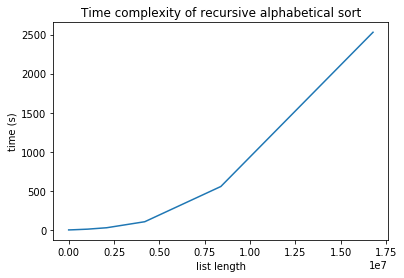

In [59]:
times.sort()
fig, ax = plt.subplots()
ax.plot(lens, times)
ax.set(ylabel='time (s)', xlabel='list length',
       title='Time complexity of recursive alphabetical sort')
plt.show()

From the graph we can see that, by increasing the length of the lists of strings, the running time increases almost quadratically. We couldn't theoretically find the worst case scenario but, thanks to the empirical solution, we deduce that the time complexity in almost quadratic, so **O(n^2)**.

## 3. Find Similar Wines!

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
with open('wine_names.txt', 'r') as G:
    print(G.read())

1. Title of Database: Wine recognition data
	Updated Sept 21, 1998 by C.Blake : Added attribute information

2. Sources:
   (a) Forina, M. et al, PARVUS - An Extendible Package for Data
       Exploration, Classification and Correlation. Institute of Pharmaceutical
       and Food Analysis and Technologies, Via Brigata Salerno, 
       16147 Genoa, Italy.

   (b) Stefan Aeberhard, email: stefan@coral.cs.jcu.edu.au
   (c) July 1991
3. Past Usage:

   (1)
   S. Aeberhard, D. Coomans and O. de Vel,
   Comparison of Classifiers in High Dimensional Settings,
   Tech. Rep. no. 92-02, (1992), Dept. of Computer Science and Dept. of
   Mathematics and Statistics, James Cook University of North Queensland.
   (Also submitted to Technometrics).

   The data was used with many others for comparing various 
   classifiers. The classes are separable, though only RDA 
   has achieved 100% correct classification.
   (RDA : 100%, QDA 99.4%, LDA 98.9%, 1NN 96.1% (z-transformed data))
   (All results usi

## K means clustering

K means clustering is a maching learning technique widely used for unsupervised learning. While conducting a k means clustering, we precisely follow certain steps which in due course of iteration produce the clustered representation of the data.


$\bullet$ step 1: k numbers of initial centroids are defined randomly


$\bullet$ step 2: objects are allocated to the clusters with respect to minimum euclidian distances


$\bullet$ step 3: mean of the attributes of the objects of repective clusters will be defined as new centroids


$\bullet$ step 4: Repeat step 2 and step 3

In [3]:

def kmeans(data):
    
    data = data.sample(frac=1).reset_index(drop=True)
    

    data['cluster'] = None
    data.iloc[0,-1]=1
    data.iloc[1,-1]=2
    data.iloc[2,-1]=3

    mean_cluster1 = list(data[data['cluster']==1].iloc[:,1:-1].mean(axis=0))
    mean_cluster2 = list(data[data['cluster']==2].iloc[:,1:-1].mean(axis=0))
    mean_cluster3 = list(data[data['cluster']==3].iloc[:,1:-1].mean(axis=0))

    distance_metric1=1000
    distance_metric2=0
    iter_count = 1
    abs_diff=1000
    
    while abs_diff>0.001:
        distance_metric2=distance_metric1
        distance_metric1=0
        for i in range(data.shape[0]):
            this_point = list(data.iloc[i,1:-1])
            euc_dist_clust1 = math.sqrt(sum([(a - b) ** 2 for a, b in zip(this_point, mean_cluster1)]))
            euc_dist_clust2 = math.sqrt(sum([(a - b) ** 2 for a, b in zip(this_point, mean_cluster2)]))
            euc_dist_clust3 = math.sqrt(sum([(a - b) ** 2 for a, b in zip(this_point, mean_cluster3)]))
            min_dist = min(euc_dist_clust1, euc_dist_clust2, euc_dist_clust3)
            if min_dist == euc_dist_clust1:
                x = 1
            elif min_dist == euc_dist_clust2:
                x = 2
            else:
                x = 3
            if data.iloc[i,-1] != x:
               
                data.iloc[i,-1] = x
            mean_cluster1 = list(data[data['cluster']==1].iloc[:,1:-1].mean(axis=0))
            mean_cluster2 = list(data[data['cluster']==2].iloc[:,1:-1].mean(axis=0))
            mean_cluster3 = list(data[data['cluster']==3].iloc[:,1:-1].mean(axis=0))
            distance_metric1 = distance_metric1+min_dist
        
        abs_diff = abs(distance_metric1-distance_metric2)
        iter_count += 1
        if (abs_diff==0):
            break
    return(data)

### Import the data

In [4]:
data=pd.read_csv('C:\\Users\Debodeep\Documents\Sapienza Learning Materials\ADM\ADMHw4\wine.txt',header=None)
data.columns=['class','Alcohol','Malic_acid','Ash','Alcalinity_of_ash','Magnesium','Total_phenols','Flavanoids','Nonflavanoid_phenols','Proanthocyanins','Color_intensity','Hue','OD280/OD315_of_diluted_wines','Proline']
#data= data.drop('class', 1)
#data= data.drop(columns=[0])
data.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### Retrieving two specific columns.

In [5]:
X = data[['Alcohol','Color_intensity']]

In [6]:
df=kmeans(X)

In [7]:
# Creating the dataset with each object allocated to a cluster
df

,Alcohol,Color_intensity,cluster
0,13.69,5.88,3
1,13.16,4.00,2
2,12.84,4.92,3
3,14.75,5.40,3
4,13.05,2.60,2
...,...,...,...
173,13.11,7.10,1
174,13.58,8.66,1
175,12.08,2.90,2
176,12.29,2.15,2


### Calculating centroids

In [8]:
# Calculating the sum of the attributes
df_sum=df.groupby(["cluster"]).sum()
df_sum

,Alcohol,Color_intensity
cluster,,
1,481.85,314.859999
2,890.35,212.740000
3,941.91,372.740000


In [9]:
# Counting the number of members in the clusters
df_count=df.groupby(["cluster"]).count()
df_count

,Alcohol,Color_intensity
cluster,,
1,36,36
2,72,72
3,70,70


In [10]:
# Clculating the values of the centroids
centroids=df_sum.iloc[0:3]/df_count.iloc[0:3,0:2]

In [11]:
centroids

,Alcohol,Color_intensity
cluster,,
1,13.384722,8.746111
2,12.365972,2.954722
3,13.455857,5.324857


In [12]:
colors = ["red","green","blue","black"]

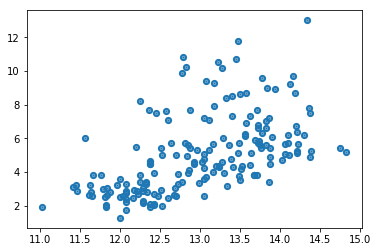

In [13]:
plt.scatter(df['Alcohol'],df["Color_intensity"],marker='.', s=20, linewidths=5)
    

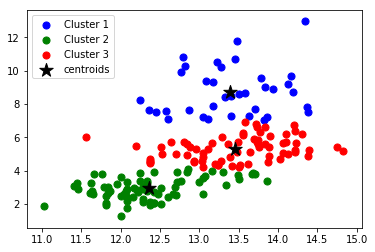

In [14]:
df['subset'] = np.select([df.cluster==1, df.cluster==2, df.cluster==3],
                         ['Cluster 1', 'Cluster 2', 'Cluster 3'])
for color, label in zip('bgrm', ['Cluster 1', 'Cluster 2', 'Cluster 3']):
    subset = df[df.subset == label]
    plt.scatter(subset.Alcohol, subset.Color_intensity, s=50, c=color, label=str(label))
plt.scatter(centroids["Alcohol"],centroids["Color_intensity"],c="black",s=200,linewidth=1,marker="*", label="centroids")
plt.legend()

#### Retrieving three specific columns.

In [57]:
Y = data[['Alcohol','Alcalinity_of_ash','Ash']]

In [58]:
df=kmeans(Y)

In [59]:
# Creating the dataset with each object allocated to a cluster
df

,Alcohol,Alcalinity_of_ash,Ash,cluster
0,13.67,18.0,1.92,2
1,13.41,18.8,2.12,2
2,12.37,19.0,2.16,2
3,13.32,21.5,2.38,3
4,14.16,20.0,2.48,2
...,...,...,...,...
173,12.87,21.5,2.48,3
174,12.29,18.0,2.21,2
175,12.08,17.5,1.70,2
176,13.29,16.8,2.68,1


#### Calculating centroids

In [60]:
# Calculating the sum of the attributes
df_sum=df.groupby(["cluster"]).sum()
df_sum

,Alcohol,Alcalinity_of_ash,Ash
cluster,,,
1,650.50,747.1,109.22
2,1036.16,1568.5,188.62
3,627.45,1154.5,123.40


In [61]:
# Counting the number of members in the clusters
df_count=df.groupby(["cluster"]).count()
df_count

,Alcohol,Alcalinity_of_ash,Ash
cluster,,,
1,48,48,48
2,81,81,81
3,49,49,49


In [62]:
# Clculating the values of the centroids
centroids=df_sum.iloc[0:3]/df_count.iloc[0:3,0:3]

In [63]:
centroids

,Alcohol,Alcalinity_of_ash,Ash
cluster,,,
1,13.552083,15.564583,2.275417
2,12.792099,19.364198,2.328642
3,12.805102,23.561224,2.518367


In [64]:
colors = ["red","green","blue","black"]

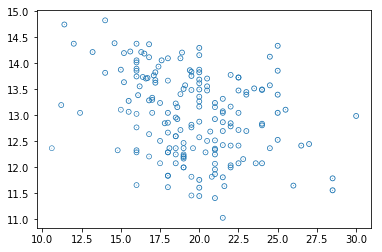

In [65]:
plt.scatter(df['Alcalinity_of_ash'],df["Alcohol"],df['Ash'],marker='.', linewidths=5)

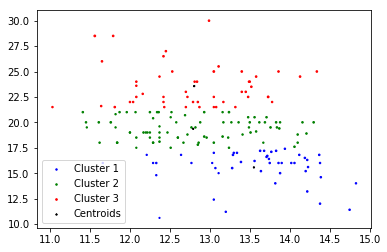

In [66]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

df['subset'] = np.select([df.cluster==1, df.cluster==2, df.cluster==3],
                         ['Cluster 1', 'Cluster 2', 'Cluster 3'])

fig = plt.figure()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4


for color, label in zip('bgrm', ['Cluster 1', 'Cluster 2', 'Cluster 3']):
    subset = df[df.subset == label]
    plt.scatter(subset.Alcohol,subset.Alcalinity_of_ash,subset.Ash,c=color, label=str(label))
plt.scatter(centroids["Alcohol"],centroids["Alcalinity_of_ash"],centroids["Ash"],marker='*',c="black",label="Centroids")
plt.legend()

#### Plotting in 3D plot

<Figure size 432x288 with 0 Axes>

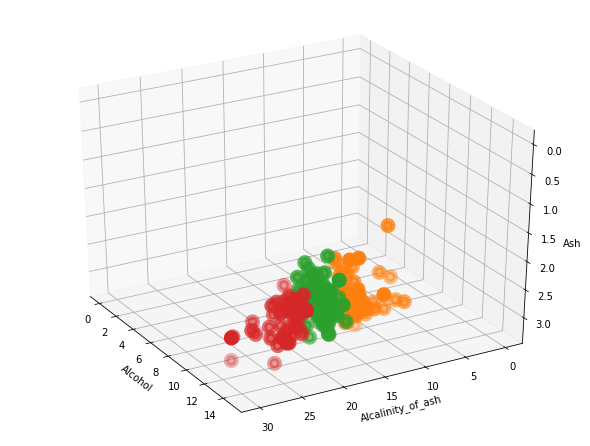

In [81]:
from mpl_toolkits.mplot3d import Axes3D
plt.clf()
fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig, elev=-150, azim=210)
for i in range(0,4):
    ax.scatter3D(df[df.cluster == i]['Alcohol'],
                df[df.cluster == i]['Alcalinity_of_ash'],
                df[df.cluster == i]['Ash'], s=100, linewidth=5)
ax.set_xlabel("Alcohol")
ax.set_ylabel("Alcalinity_of_ash")
ax.set_zlabel("Ash")
fig.show()

## 4. K-means can go wrong!

Since this kind of clustering is based on the distribution of data and we choose our initial centroids by considering the range of data, the way in which data are distributed would affect the centroids.

1-If the data does not normalize the range of picking the initial centroids which are randomly selected from the range of data. The initial centroids are needed to be updated several times to be an appropriate cluster and be close to remain data. In some cases, there is the possibility that the outlier data with a low density be considered as a separated cluster.

2-In addition, in the case data aggregation place in far distances from each other, the initial centroids will lie on the aggregated sides. Then it would take more time and steps to reach the optimum clusters for all data. 

3- In k-means clustering, it is assumed that all clusters have the same radius from their centroids. So, when the distribution radius of data in a cluster is more than others, it could fail.

4-When density in a cluster is more than others, the k-means clustering will fail due to its assumption of the equal number of points in each cluster